# Intent Classification BERT Model

BERT model for text Intent classification to Train and evaluate for detecting seven intents.


#### Setting up libraries and frameworks

In [1]:
!pip install tensorflow-gpu >> /dev/null
!pip install --upgrade grpcio >> /dev/null
!pip install tqdm  >> /dev/null
!pip install bert-for-tf2 >> /dev/null
!pip install sentencepiece >> /dev/null

ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc2 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.


#### Import Libraries

In [2]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data

The data contains various user queries categorized into seven intents. It is hosted on [GitHub](https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines) and is first presented in [this paper](https://arxiv.org/abs/1805.10190).

Here are the intents:

- SearchCreativeWork (e.g. Find me the I, Robot television show)
- GetWeather (e.g. Is it windy in Boston, MA right now?)
- BookRestaurant (e.g. I want to book a highly rated restaurant for me and my boyfriend tomorrow night)
- PlayMusic (e.g. Play the last track from Beyoncé off Spotify)
- AddToPlaylist (e.g. Add Diamonds to my roadtrip playlist)
- RateBook (e.g. Give 6 stars to Of Mice and Men)
- SearchScreeningEvent (e.g. Check the showtimes for Wonder Woman in Paris)


I’ve done a bit of preprocessing and converted the JSON files into easy to use/load CSVs. Let’s download them:

In [40]:
!gdown --id 147iP5BWUXBygSqzPoaZil3J5WIbUEGfS --output train.csv
!gdown --id 1Qym2ALCIzkG3sq48OWdX93XqNII1FK6B --output valid.csv
!gdown --id 12Vihv8BgCO8YhGjprY7ddA8o9vOxEK-D --output test.csv

Downloading...
From: https://drive.google.com/uc?id=147iP5BWUXBygSqzPoaZil3J5WIbUEGfS
To: /content/train.csv
100% 43.1k/43.1k [00:00<00:00, 19.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Qym2ALCIzkG3sq48OWdX93XqNII1FK6B
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 38.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=12Vihv8BgCO8YhGjprY7ddA8o9vOxEK-D
To: /content/test.csv
100% 799k/799k [00:00<00:00, 109MB/s]


We’ll load the data into data frames and expand the training data by merging the training and validation intents:



In [ ]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
train = train.append(valid).reset_index(drop=True)

In [43]:
train.shape

(1400, 2)

In [44]:
train.head()

,text,intent
0,add sabrina salerno to the grime instrumentals...,AddToPlaylist
1,i want to bring four people to a place that s ...,BookRestaurant
2,put lindsey cardinale into my hillary clinton ...,AddToPlaylist
3,will it snow in mt on june 13 2038,GetWeather
4,play signe anderson chant music that is newest,PlayMusic


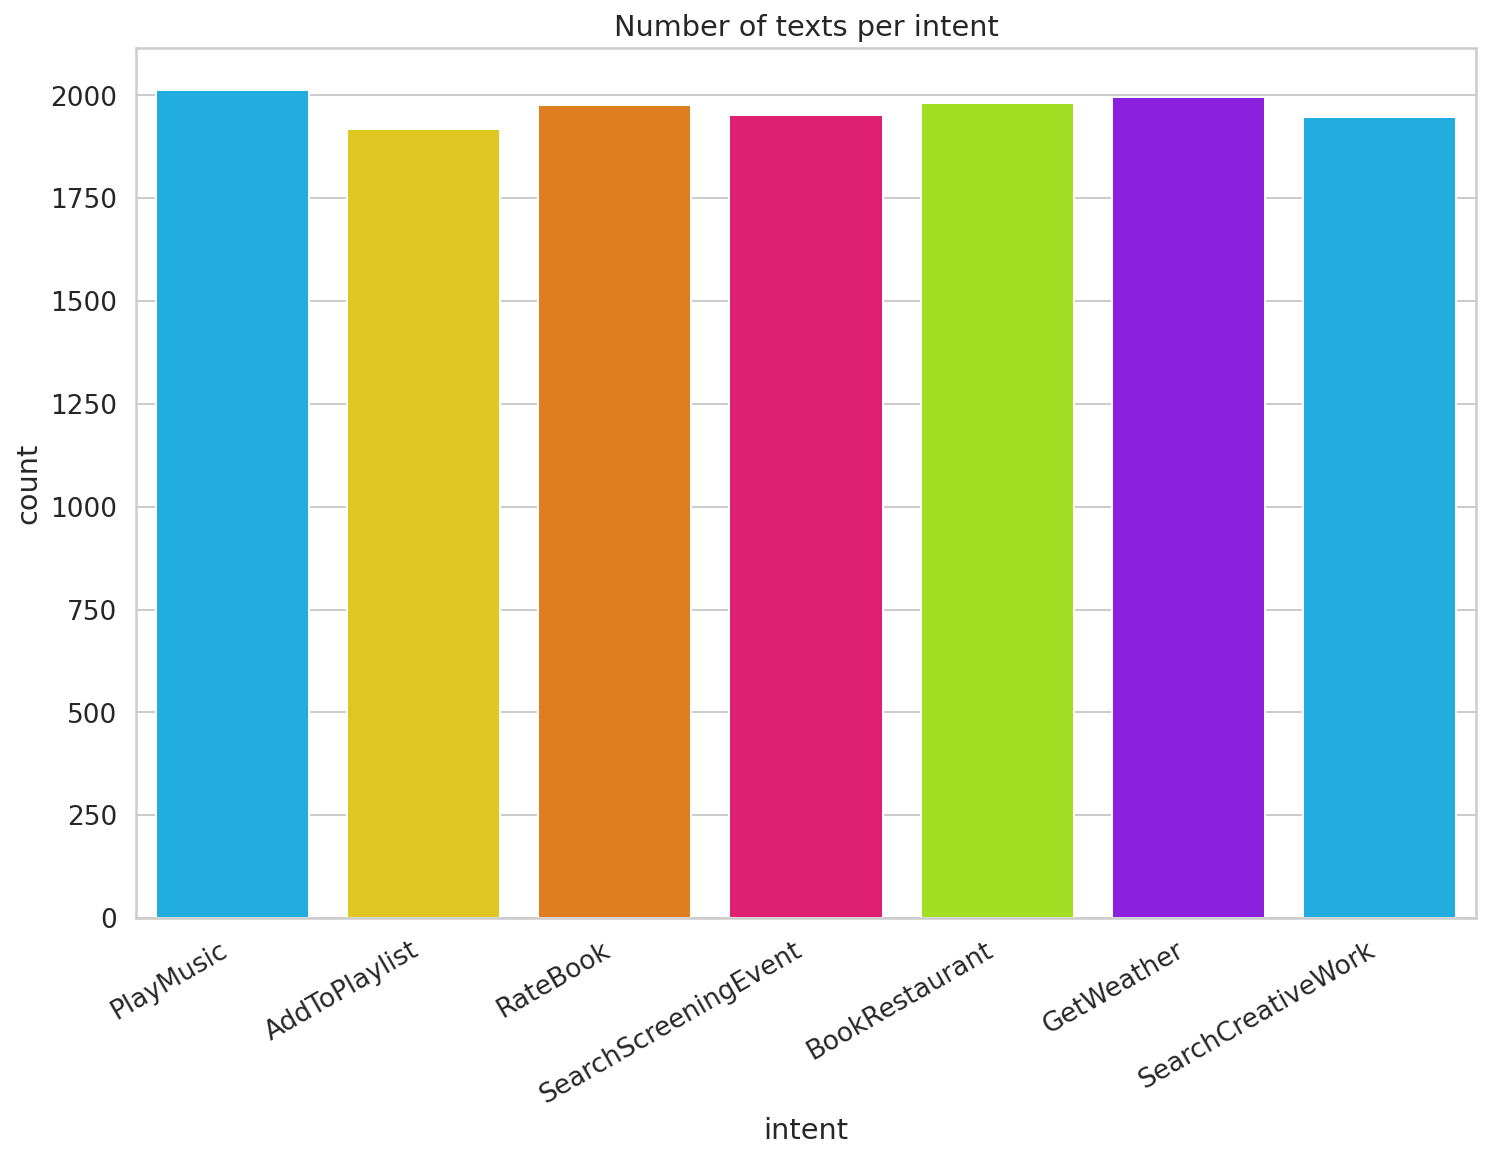

In [8]:
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per intent")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Intent Recognition with BERT

In [9]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-04-10 04:58:40--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  62.5MB/s    in 6.2s    

2020-04-10 04:58:47 (62.5 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [10]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [ ]:
os.makedirs("model", exist_ok=True)

In [ ]:
!mv uncased_L-12_H-768_A-12/ model

In [ ]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

We need to convert the raw texts into vectors that we can feed into our model. We’ll go through 3 steps:

- Tokenize the text
- Convert the sequence of tokens into numbers
- Pad the sequences so each one has the same length

In [ ]:
class IntentDetectionData:
  DATA_COLUMN = "text"
  LABEL_COLUMN = "intent"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [15]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
tokenizer.tokenize("I can't wait to visit Bulgaria again!")

['i', 'can', "'", 't', 'wait', 'to', 'visit', 'bulgaria', 'again', '!']

In [16]:
tokens = tokenizer.tokenize("I can't wait to visit Bulgaria again!")
tokenizer.convert_tokens_to_ids(tokens)

[1045, 2064, 1005, 1056, 3524, 2000, 3942, 8063, 2153, 999]

In [ ]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
        
  return model

## Training

In [18]:
classes = train.intent.unique().tolist()

data = IntentDetectionData(train, test, tokenizer, classes, max_seq_len=128)

13784it [00:03, 3572.03it/s]
700it [00:00, 3552.31it/s]


max seq_len 38


In [19]:
data.train_x.shape

(13784, 38)

In [20]:
data.train_x[0]

array([  101,  4952,  2000,  2225,  3676,  2213,  2632, 25438, 27395,
        2006,  8224,  2189,   102,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0])

In [21]:
data.train_y[0]

0

In [22]:
data.max_seq_len

38

In [23]:
model = create_model(data.max_seq_len, bert_ckpt_file)

bert shape (None, 38, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f6596ba1f98> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 38)]              0         
_________________________________________________________________
bert (BertModelLayer)        (None, 38, 768)           108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 5383  

In [ ]:
model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)

In [27]:
log_dir = "log/intent_detection/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5,
  callbacks=[tensorboard_callback]
)

Train on 12405 samples, validate on 1379 samples
Epoch 1/5
12405/12405 [==============================] - 333s 27ms/sample - loss: 1.3082 - acc: 0.8708 - val_loss: 1.1827 - val_acc: 0.9819
Epoch 2/5
12405/12405 [==============================] - 313s 25ms/sample - loss: 1.1830 - acc: 0.9846 - val_loss: 1.1790 - val_acc: 0.9862
Epoch 3/5
12405/12405 [==============================] - 313s 25ms/sample - loss: 1.1783 - acc: 0.9877 - val_loss: 1.1771 - val_acc: 0.9877
Epoch 4/5
12405/12405 [==============================] - 315s 25ms/sample - loss: 1.1765 - acc: 0.9894 - val_loss: 1.1773 - val_acc: 0.9884
Epoch 5/5
12405/12405 [==============================] - 313s 25ms/sample - loss: 1.1743 - acc: 0.9912 - val_loss: 1.1750 - val_acc: 0.9906


## Evaluation

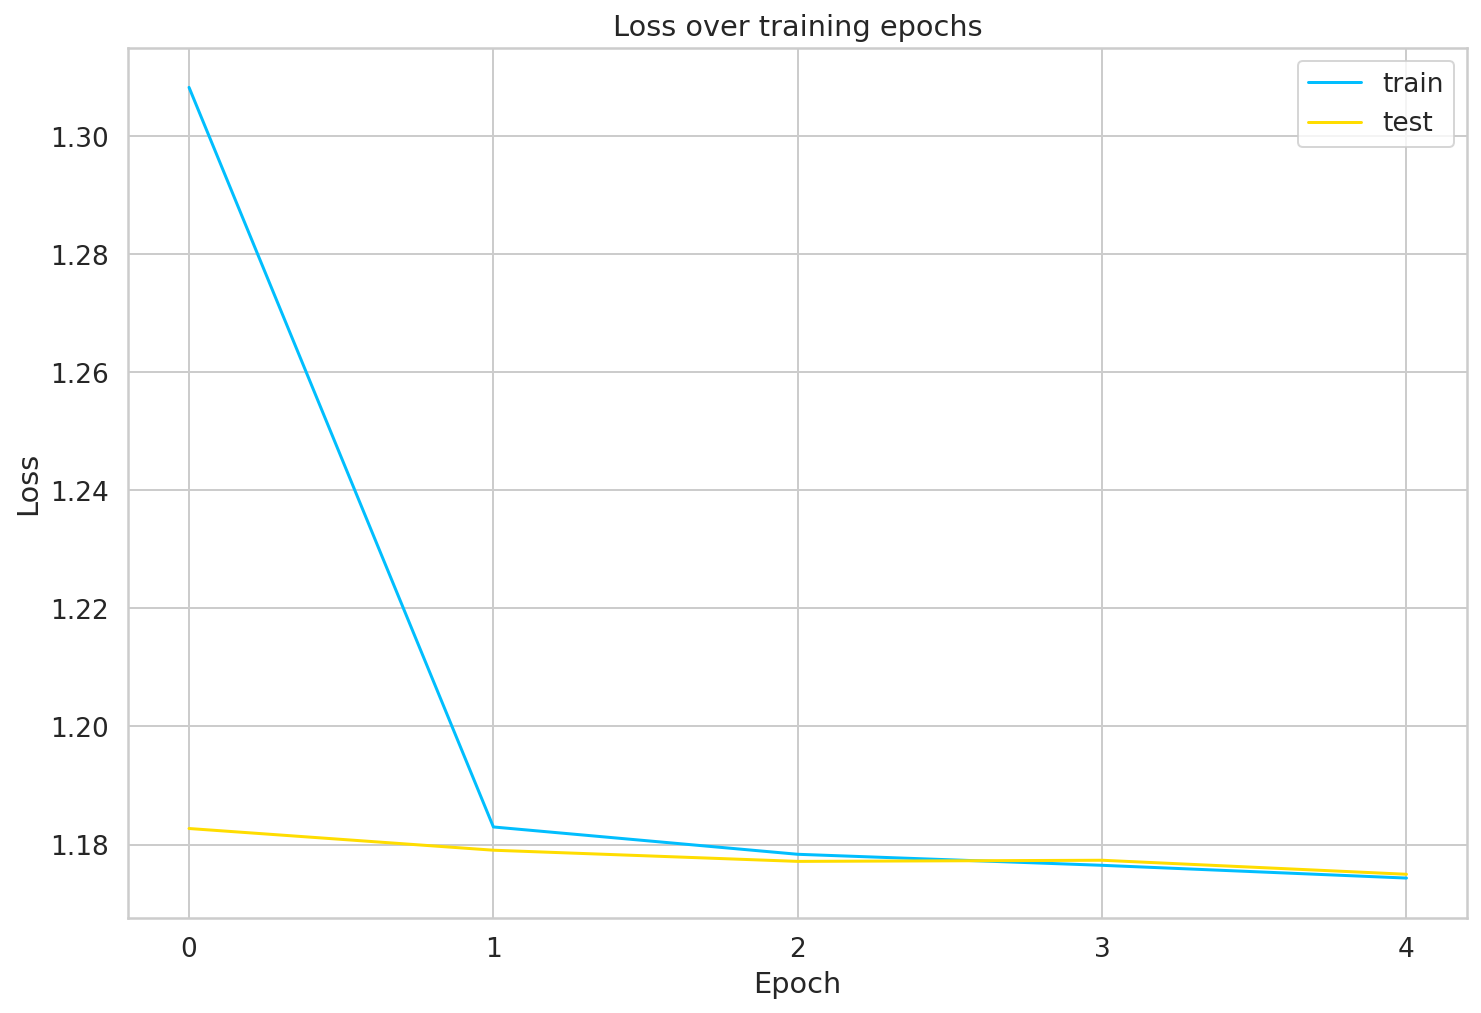

In [32]:
# Loss over training epochs

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

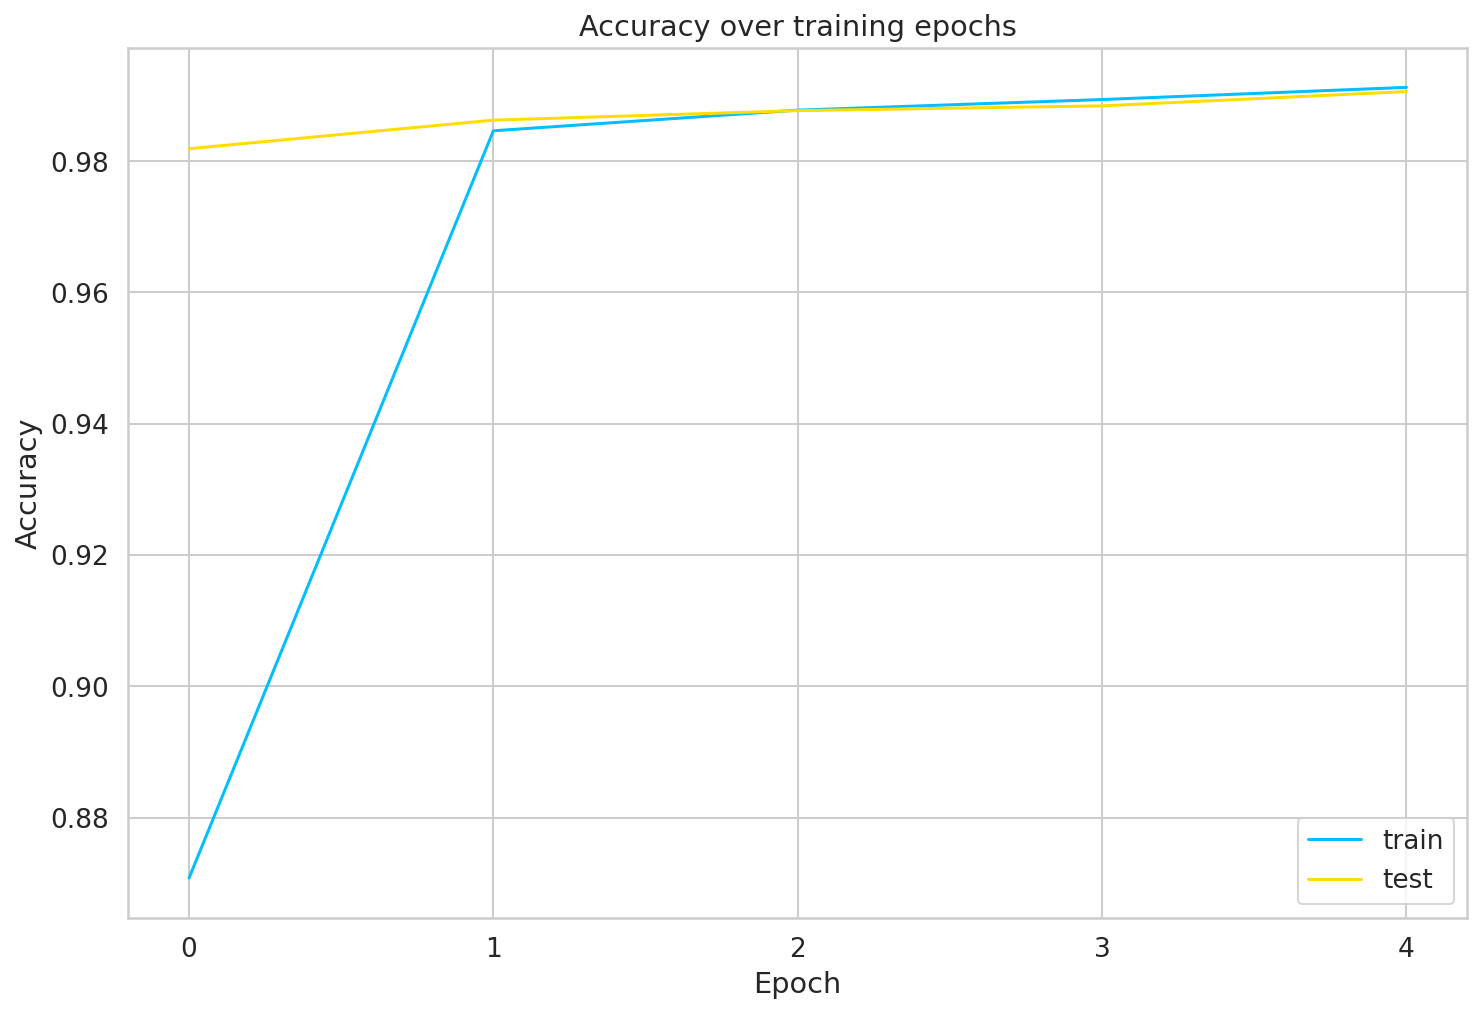

In [33]:
# Accuracy over training epochs

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [34]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

700/700 [==============================] - 3s 4ms/sample - loss: 1.1912 - acc: 0.9743
train acc 0.99281776
test acc 0.9742857


In [ ]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [36]:
print(classification_report(data.test_y, y_pred, target_names=classes))

                      precision    recall  f1-score   support

           PlayMusic       0.96      0.99      0.97        86
       AddToPlaylist       1.00      1.00      1.00       124
            RateBook       1.00      1.00      1.00        80
SearchScreeningEvent       1.00      0.90      0.95       107
      BookRestaurant       0.98      1.00      0.99        92
          GetWeather       1.00      0.98      0.99       104
  SearchCreativeWork       0.90      0.96      0.93       107

            accuracy                           0.97       700
           macro avg       0.98      0.98      0.97       700
        weighted avg       0.98      0.97      0.97       700



In [ ]:
cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

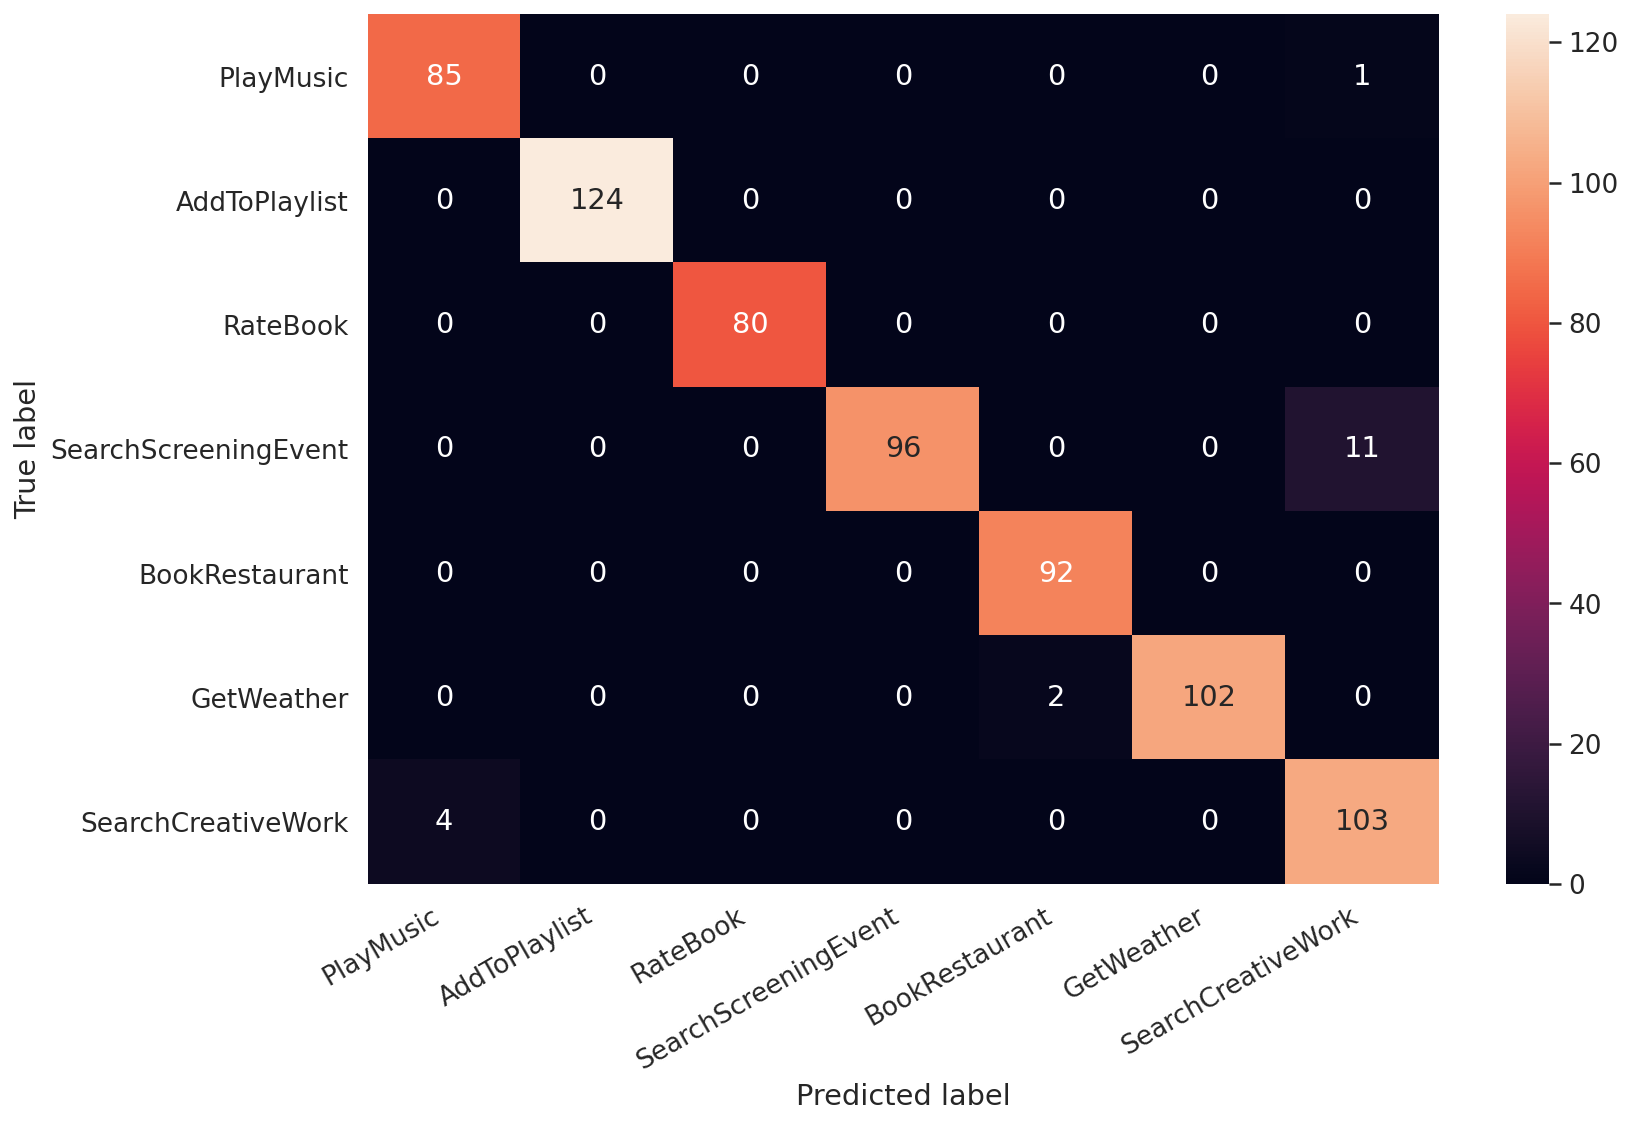

In [38]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [39]:
sentences = [
  "Play our song now",
  "Rate this book as awful",
  "listen to westbam alumb allergic on google music"
]

pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nintent:", classes[label])
  print()

text: Play our song now 
intent: PlayMusic

text: Rate this book as awful 
intent: RateBook

text: listen to westbam alumb allergic on google music 
intent: PlayMusic



# References

- https://mccormickml.com/2019/07/22/BERT-fine-tuning/
- https://github.com/snipsco/nlu-benchmark/tree/master/2017-06-custom-intent-engines
- https://jalammar.github.io/illustrated-bert/
- https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03
- https://www.reddit.com/r/MachineLearning/comments/ao23cp/p_how_to_use_bert_in_kaggle_competitions_a/